# 1. Setting up the Environment

In [1]:
from IPython.display import clear_output

'''
!git clone https://github.com/Anushaaelango/brain-tumor # load new dataset + annotations
!pip3 install pycocotools

rm -rf brain-tumor/.git/
rm -rf Mask_RCNN/.git/
'''

clear_output()

In [2]:
import os 
import sys
from tqdm import tqdm
import cv2
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random

# Root directory of the project
ROOT_DIR = os.path.abspath('/home/sdp/Mask_RCNN-TF2/')

# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log

import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))

from samples.coco import coco

plt.rcParams['figure.facecolor'] = 'white'

clear_output()

In [3]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:

MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # directory to save logs and trained model
# ANNOTATIONS_DIR = 'brain-tumor/data/new/annotations/' # directory with annotations for train/val sets
DATASET_DIR = 'brain-tumor/data_cleaned/' # directory with image data
DEFAULT_LOGS_DIR = 'logs' 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)    


In [5]:
from tumor_config import TumorConfig
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [6]:
from brain_scan_dataset import BrainScanDataset

# 2. Mask R-CNN Model

In [7]:
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

2023-11-05 10:31:53.497896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-05 10:31:53.521936: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'proposal_targets/cond/output/_16'


In [8]:
# Training dataset.
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=1,
    layers='heads'
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/tumor_detector20231105T1031/mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcn

/home/sdp/.local/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-11-05 10:31:54.963110: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_mask/bias/Assign' id:7584 op device:{requested: '', assigned: ''} def:{{{node mrcnn_mask/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mrcnn_mask/bias, mrcnn_mask/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-05 10:31:56.782180: W tensorflow/c/c_api.cc:305] Operation '{name:'range' id:9905 op device:{requested: '', assigned: ''} def:{{{node range}} = Range[Tidx=DT_INT32, _has_manual_control_dependencies=true](range/start, Rank, range/delta)}}'

  1/100 [..............................] - ETA: 9:10 - batch: 0.0000e+00 - size: 1.0000 - loss: 45.6106 - rpn_class_loss: 31.3307 - rpn_bbox_loss: 7.7400 - mrcnn_class_loss: 6.5399 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

2023-11-05 10:32:19.788102: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-05 10:32:19.788129: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


  2/100 [..............................] - ETA: 1:15 - batch: 0.5000 - size: 1.0000 - loss: 36.1959 - rpn_class_loss: 26.2916 - rpn_bbox_loss: 6.6342 - mrcnn_class_loss: 3.2700 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00    

2023-11-05 10:32:20.446993: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-11-05 10:32:20.553752: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-11-05 10:32:20.554908: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: logs/tumor_detector20231105T1031/plugins/profile/2023_11_05_10_32_20/training.xplane.pb


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 5.1964 - rpn_class_loss: 0.6437 - rpn_bbox_loss: 2.8916 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 1.4082 - mrcnn_mask_loss: 0.1770

/home/sdp/.local/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-05 10:34:43.965282: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/AddN' id:11024 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=5, T=DT_FLOAT, _has_manual_control_dependencies=true](mul, mul_1, mul_2, mul_3, mul_4)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-05 10:34:44.641614: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key:

100/100 [==============================] - 275s 3s/step - batch: 49.5000 - size: 1.0000 - loss: 5.1964 - rpn_class_loss: 0.6437 - rpn_bbox_loss: 2.8916 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 1.4082 - mrcnn_mask_loss: 0.1770 - val_loss: 14.8165 - val_rpn_class_loss: 0.5876 - val_rpn_bbox_loss: 14.2289 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00


In [9]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights from  logs/tumor_detector20231105T1031/mask_rcnn_tumor_detector_0001.h5


2023-11-05 10:36:54.419182: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_mask/bias/Assign' id:7584 op device:{requested: '', assigned: ''} def:{{{node mrcnn_mask/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mrcnn_mask/bias, mrcnn_mask/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Re-starting from epoch 1


In [10]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)

# 3. Results

# 3.1 Validation Set

In [11]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

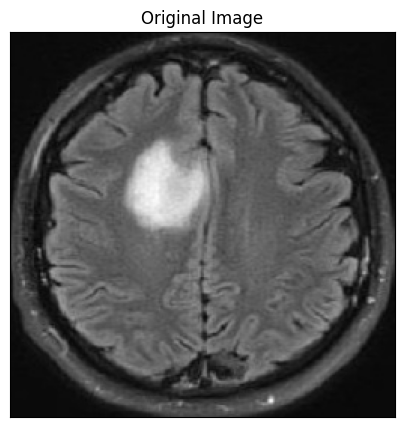

/home/sdp/.local/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-05 10:36:56.532480: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_mask_bn4_1/moving_variance/Assign' id:21430 op device:{requested: '', assigned: ''} def:{{{node mrcnn_mask_bn4_1/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mrcnn_mask_bn4_1/moving_variance, mrcnn_mask_bn4_1/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-05 10:36:58.638763: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in Predict

ValueError: shapes (24,1048576) and (3136,1) not aligned: 1048576 (dim 1) != 3136 (dim 0)

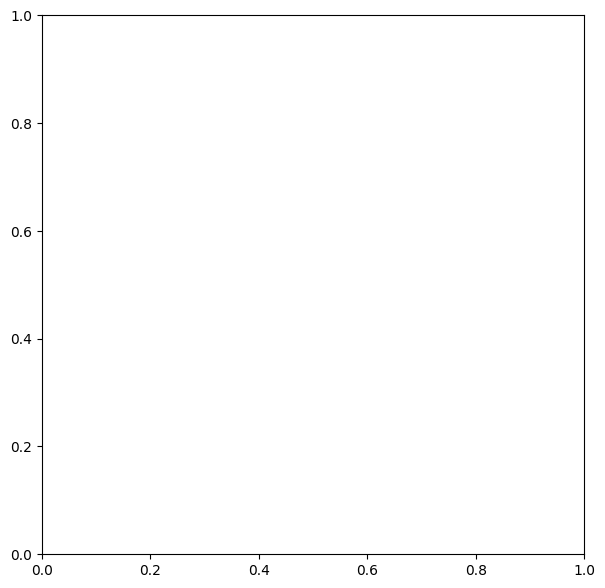

In [12]:
ind = 0
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)